In [2]:
!pip install ..
#!pip install git+https://github.com/outbreak-info/python-outbreak-info@wastewater_sprint

Processing /Users/sarahrandall/Python-outbreak-info
  Preparing metadata (setup.py) ... done
  Created wheel for python-outbreak-info: filename=python_outbreak_info-2.0.0-py3-none-any.whl size=18338 sha256=583ada9b1cdca80c2906d27c5645d04b4dae4236647f6308a9dbda3e2c82b2e8
  Stored in directory: /Users/sarahrandall/Library/Caches/pip/wheels/6f/2b/e7/3ed0c40d63901a9ba71e11202a6320922e8c98a9d9afcfcad4
Successfully built python-outbreak-info
  Attempting uninstall: python-outbreak-info
    Found existing installation: python-outbreak-info 2.0.0
    Uninstalling python-outbreak-info-2.0.0:
      Successfully uninstalled python-outbreak-info-2.0.0


In [18]:
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.dates as mdates

matplotlib.rcParams['hatch.linewidth'] = 0.5
matplotlib.rcParams['font.family'] ='sans-serif'
locator = mdates.MonthLocator(bymonthday=1)


In [4]:
import os; os.getcwd()

'/Users/sarahrandall/Python-outbreak-info/tests'

In [16]:
from outbreak_data import authenticate_user
from outbreak_tools import outbreak_tools

In [3]:
authenticate_user.authenticate_new_user()

Please open this url in a web browswer and authenticate with your GISAID credentials:  https://gpsapi.epicov.org/epi3/gps_authenticate/NLTEUIWZGTKWCHCCNGNDXWDBLLRTMWFVCVWMOMHVHRGGHSUTFPIWXSOOLFGOMVCSTQQHHTUMBYLMENEMHRNPZEWXZQDTUJBHBOPTJMKIJOCLJRXYDOVYZZYKQOFNBPIM
Waiting for authorization response... [Press Ctrl-C to abort]
Authenticated successfully!

    TERMS OF USE for Python Package and
    Reminder of GISAID's Database Access Agreement
    Your ability to access and use Data in GISAID, including your access and
    use of same via R Package, is subject to the terms and conditions of
    GISAID's Database Access Agreement (“DAA”) (which you agreed to
    when you requested access credentials to GISAID), as well as the
    following terms:
    1. You will treat all data contained in the R Package consistent with
    other Data in GISAID and in accordance with GISAID's Database Access
    Agreement;
    2. You will not distribute, or re-distribute Data made available through
    GIS

In [17]:
def plot_out(fname):
    plt.savefig(fname, format='pdf', bbox_inches='tight')
    plt.show();

In [19]:
def binom_kernel(n, squeeze=0):
    return np.array([scipy.special.binom(n+2*squeeze, x) for x in np.arange(n)+squeeze])
    
smooth = binom_kernel(7*5, 35) # 21
# plt.plot(smooth)

#### pull ww data

In [20]:
state = "California"
state_id = 'USA_US-CA'
startdate, enddate = "2023-09-02", "2024-01-02"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate], server='dev.outbreak.info') #Get ww sample ids in a certain area 
ww_lineages = outbreak_data.get_wastewater_lineages(ww_samples, server='dev.outbreak.info')
#ww_mutations = outbreak_data.get_wastewater_mutations(ww_samples, server='dev.outbreak.info')

In [21]:
ww_prevalences = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1], log=False)
ww_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=1, log=False)
ww_prevalences_daily, ww_prevalences_daily_varis = outbreak_tools.datebin_and_agg(ww_lineages, weights=outbreak_tools.get_ww_weights(ww_lineages), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, log=False, variance=True)

In [22]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1)

In [23]:
clinical_prevalences = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, freq='7D', rolling=[1,4,1])
clinical_prevalences_daily_unsmoothed = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=1, freq='D', log=False)
clinical_prevalences_daily, clinical_prevalences_daily_varis = outbreak_tools.datebin_and_agg(clinical_samples, weights=clinical_samples['total_count'], startdate=startdate, enddate=enddate, rolling=smooth, freq='D', log=False, variance=True)

#### get the lineage tree

In [14]:
tree = outbreak_clustering.get_compressed_tree() # Gets the tree for lineages 
lineage_key = outbreak_clustering.get_lineage_key(tree)

NameError: name 'outbreak_clustering' is not defined

In [15]:
samples_per_site = ww_samples['sra_accession'].groupby(ww_samples['collection_site_id']).nunique()

date_range_per_site = ww_samples.index.to_series().apply(pd.to_datetime).groupby(ww_samples['collection_site_id']) #.apply(pd.to_datetime)
date_range_per_site = date_range_per_site.apply(lambda x: x.max() - x.min())

sites_for_vl = (date_range_per_site.apply(lambda x: x.days >= 14)) & (samples_per_site >= 3)
samples_for_vl = ww_samples[ww_samples['collection_site_id'].isin(list(sites_for_vl.index[sites_for_vl]))]

#numer of samples per site to estimate viral load data

#### cluster lineages on combined prevalences

In [260]:
ww_prev_data = ww_prevalences.mul(viral_load_weekly, axis=0)[-6:].sum()
clinical_prev_data = clinical_prevalences.mul(viral_load_weekly, axis=0)[-6:].sum()
combined_prevalences = (ww_prev_data/ww_prev_data.sum()).add(clinical_prev_data/clinical_prev_data.sum(), fill_value=0)

In [261]:
clusters = outbreak_clustering.cluster_lineages(combined_prevalences, tree, lineage_key=lineage_key, n=10, alpha=0.25) # Generates cluster groups given prevalneces and tree

#### prepare data for plotting

In [ ]:
#applies groups to aggregated data
clustered_cl_prevalences, root_lineages, isnatural = outbreak_tools.cluster_df(clinical_prevalences.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily.fillna(0), clusters, tree, lineage_key)
clustered_cl_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(clinical_prevalences_daily_varis.fillna(0), clusters, tree, lineage_key, norm=False)
clustered_ww_prevalences, _, _ = outbreak_tools.cluster_df(ww_prevalences.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily_unsmoothed, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_unsmoothed.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily.fillna(0), clusters, tree, lineage_key)
clustered_ww_prevalences_daily_varis, _, _ = outbreak_tools.cluster_df(ww_prevalences_daily_varis.fillna(0), clusters, tree, lineage_key, norm=False)

#daily data + smoothing + week vs data - prepares data for plotting

In [264]:
ww_muts = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='7D', trustna=0.001, log=True, norm=False)
ww_muts_daily = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='D', trustna=0.001, log=True, norm=False)
ww_muts_daily_s, ww_muts_daily_vars = outbreak_tools.datebin_and_agg(ww_mutations4, weights=outbreak_tools.get_ww_weights(ww_mutations4), startdate=startdate, enddate=enddate, freq='D', rolling=smooth, trustna=0.001, variance=True, log=True, norm=False)

In [265]:
cl_mut = outbreak_data.lineage_cl_prevalence(pango_lin='.', descendants=True, location=state_id, datemin=startdate, datemax=enddate, mutations='ORF1a:V3593F')

cl_prev_unsmoothed = outbreak_tools.datebin_and_agg(cl_mut.rename(columns={'proportion': 'prevalence'}), norm=False, freq='D', rolling=1)
cl_prev, cl_var = outbreak_tools.datebin_and_agg(cl_mut.rename(columns={'proportion': 'prevalence'}), norm=False, freq='D', rolling=smooth, variance=True)

#### wastewater plots

In [267]:
months = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

def format_dateinterval_axis(ax, index, every_n=4, narrow=0, shift=0, tickRight=False):
    def format(x, pos):
        side = lambda y: [y.mid, y.left, y.right][(x==0) + 2*(x==len(index)-1)]
        month = side(index.get_level_values(0)[x]).date().strftime('%m')
        pmonth = side(index.get_level_values(0)[x-1]).date().strftime('%m')
        return months[month] if month != pmonth else ''
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format))
    ax.set_xticks(np.arange(0, len(index), 1))
    ax.set_xlim(narrow+shift-0.5, len(index)-0.5-narrow+shift)
    ax.set_xlabel(None)
    if not tickRight:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['left', 'top']].set_visible(False)
        ax.yaxis.tick_right()

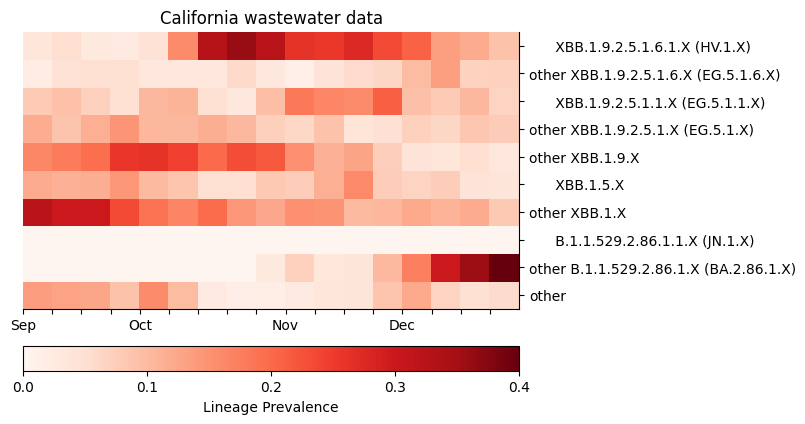

In [279]:
#ignore
fig, ax = plt.subplots()
plt.pcolor(clustered_ww_prevalences.T, cmap='Reds', vmin=0, vmax=0.4)
plt.xticks(np.arange(0.5, len(clustered_ww_prevalences.index), 1), clustered_ww_prevalences.index)
plt.yticks(np.arange(0.5, len(clustered_ww_prevalences.columns), 1), clustered_ww_prevalences.columns)
format_dateinterval_axis(plt.gca(), clustered_ww_prevalences.index, shift=0.5, tickRight=True)
plt.title(f'{state} wastewater data')
cbar = plt.colorbar(location='bottom',pad = 0.1)
cbar.ax.set_xticks([0,0.1,0.2,0.3,0.4])
cbar.set_label('Lineage Prevalence')

plot_out('lin_prev_matrix_ww.pdf')

#### combined plots

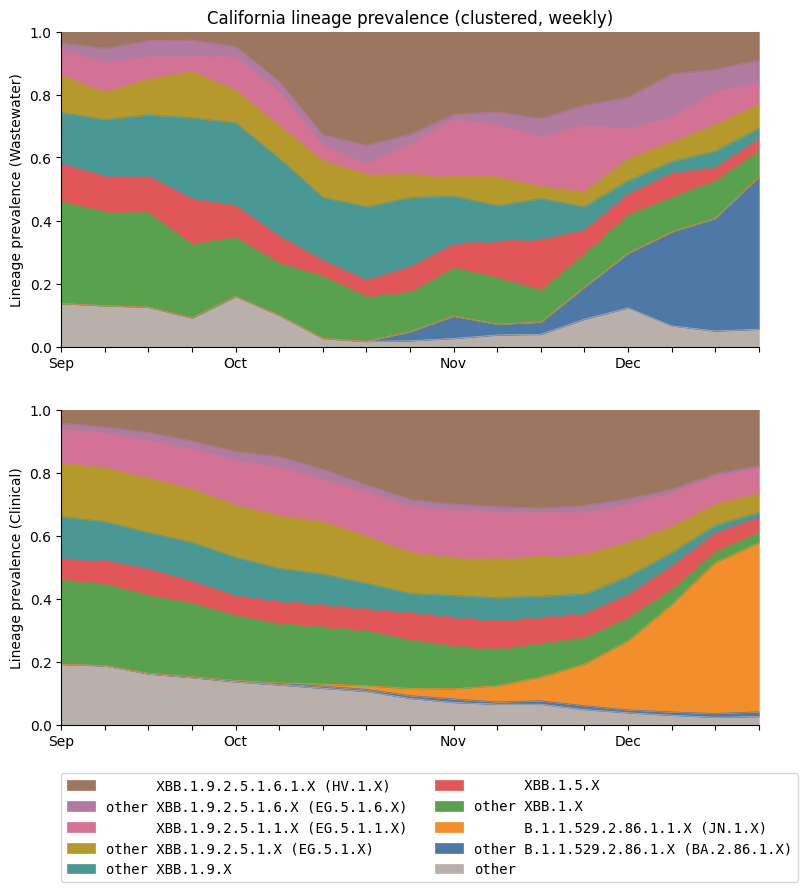

In [282]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(9,9))

cm = ["#bab0ab", "#4E79A7", "#f28e2b", "#59a14f","#e15759", "#499894","#B6992D",  "#D37295", "#B07AA1","#9D7660", "#bcbd22", "#aecBe8", "#FFBE7D",  "#8CD17D", "#FF9D9A",  "#86BCB6", "#F1CE63","#FABFD2",  "#D4A6C8", "#D7B5A6",  "#79706E"]

clustered_ww_prevalences.plot(kind='area', stacked=True, color=cm[:len(clustered_ww_prevalences)], linewidth=0.5, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Lineage prevalence (Wastewater)')
axs[0].spines[['right', 'top']].set_visible(False)

clustered_cl_prevalences.plot(kind='area', stacked=True, color=cm[:len(clustered_cl_prevalences)], linewidth=0.5, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Lineage prevalence (Clinical)')
axs[1].spines[['right', 'top']].set_visible(False)

format_dateinterval_axis(axs[1], clustered_ww_prevalences.index, narrow=0.5)
axs[1].legend(loc=(0,-0.5), prop={"family":"monospace"}, reverse=True, ncols=2)
axs[0].legend().remove()
axs[0].set_title(f'{state} lineage prevalence (clustered, weekly)')

axs[0].tick_params(axis='both', which='both',labelbottom=True)
axs[1].tick_params(axis='both', which='both')
plt.subplots_adjust(hspace=0.2)

plot_out('lin_prev_stacked_stacked.pdf')

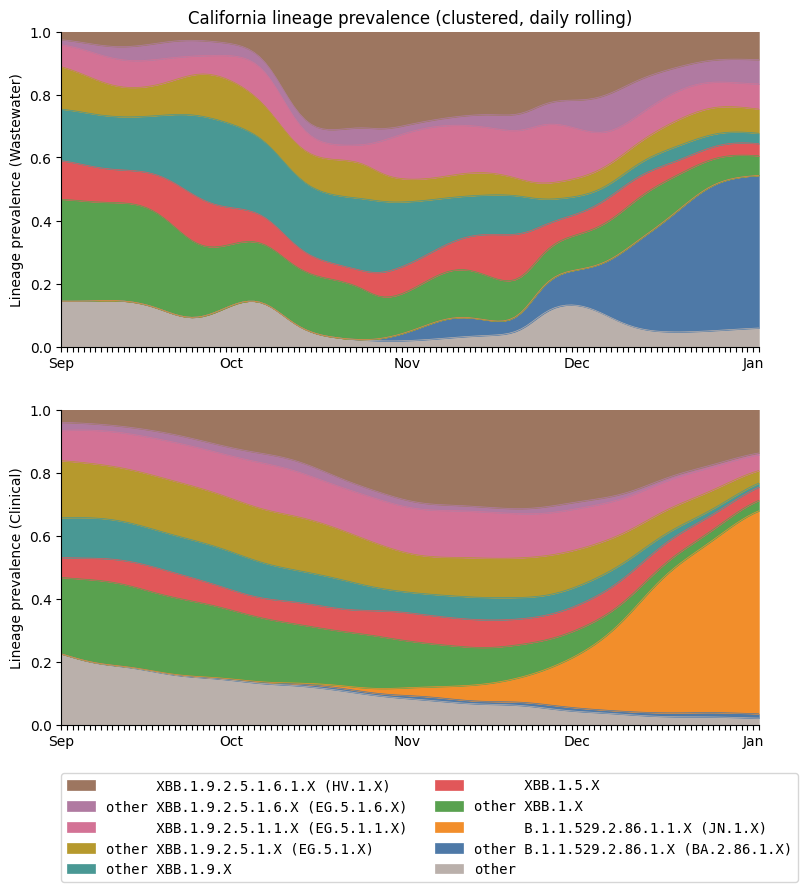

In [283]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(9,9))

clustered_ww_prevalences_daily.plot(kind='area', stacked=True, color=cm[:len(clustered_ww_prevalences_daily)], linewidth=0.5, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Lineage prevalence (Wastewater)')
axs[0].spines[['right', 'top']].set_visible(False)

clustered_cl_prevalences_daily.plot(kind='area', stacked=True, color=cm[:len(clustered_cl_prevalences_daily)], linewidth=0.5, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('Lineage prevalence (Clinical)')
axs[1].spines[['right', 'top']].set_visible(False)

format_dateinterval_axis(axs[1], clustered_ww_prevalences_daily.index, narrow=0.5)
axs[1].legend(loc=(0,-0.5), prop={"family":"monospace"}, reverse=True, ncols=2)
axs[0].legend().remove()
axs[0].set_title(f'{state} lineage prevalence (clustered, daily rolling)')

axs[0].tick_params(axis='both', which='both',labelbottom=True)
axs[1].tick_params(axis='both', which='both')
plt.subplots_adjust(hspace=0.2)

plot_out('lin_prev_stacked_stacked.pdf')

In [284]:
groups = outbreak_clustering.gather_groups(clusters, combined_prevalences)
clustered_prevalences = pd.concat([clustered_ww_prevalences, clustered_cl_prevalences], keys=['A_wastewater', 'B_clinical'])
gcolors = [[colors[root_lineages.index(n['name'])] for n in g] for g in groups]
groups = [ clustered_prevalences[
        [clustered_prevalences.columns[root_lineages.index(node['name'])] for node in group]
    ].swaplevel(axis='rows').sort_index() for group in groups]

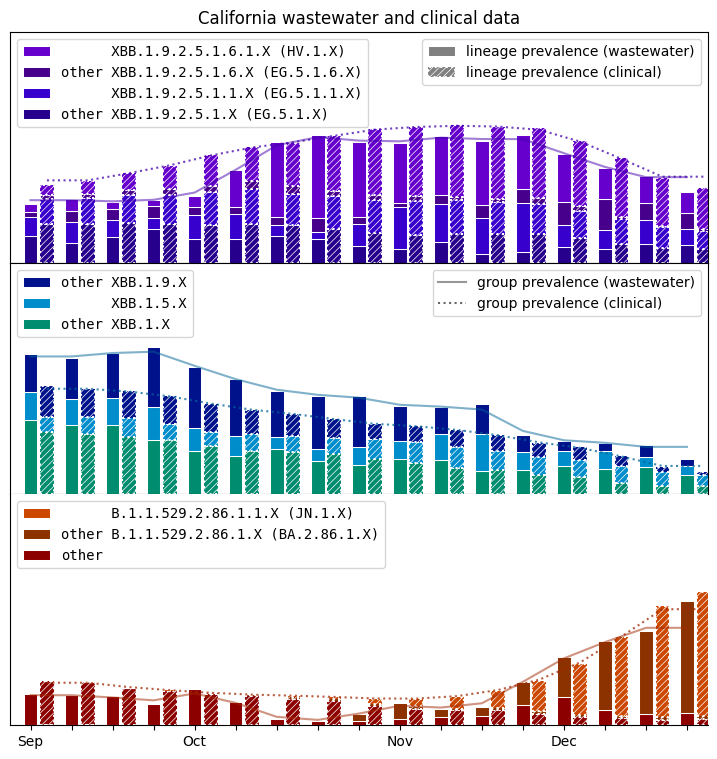

In [285]:
fig, axs = plt.subplots(len(groups),1, sharex=True, figsize=(9,9))
barstyle = { 'linewidth': 0.75, 'edgecolor':'white' }
cbarstyle = { 'linewidth': 1.5, 'linestyle':':', 'hatch': '/////' }
linestyle = { 'alpha': 0.5 }
clinestyle = { 'alpha': 0.75, 'linestyle': ':' }

def trendline(lingroup):
    line = lingroup.sum(axis=1)
    line[lingroup.isna().all(axis=1)] = pd.NA
    line = line.interpolate().rolling(3, closed=None, center=True).mean()/2 + line.interpolate()/2
    return line.bfill().ffill()

for i, (ax, g, c) in enumerate(zip(axs, groups, gcolors)):
    ww = g.xs('A_wastewater', level=1)
    cl = g.xs('B_clinical', level=1)
    ww.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **barstyle)
    ax.add_artist(ax.legend(loc='upper left', prop={"family":"monospace"}, reverse=True)) # save lin legend
    cl.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **(barstyle|cbarstyle))
    for cbar in ax.patches[-cl.size:]: cbar.set_x(cbar.get_x() + 0.4) # x-offset clinical bars
    trendline(ww).plot(color=np.mean(c, axis=0), ax=ax, **linestyle)
    trendline(cl).plot(color=np.mean(c, axis=0), ax=ax, **(linestyle|clinestyle))
    ax.lines[-1].set_xdata(ax.lines[-1].get_xdata() + 0.4) # x-offset clinical trend to match bars
    ax.legend().remove() # skip auto legend
    ax.set_yticks([])
    ax.set_ylim(0,1)

axs[0].set_title(f'{state} wastewater and clinical data')
axs[0].legend([ # custom legend for ww v cl bars
        matplotlib.patches.Patch(facecolor='gray', **barstyle),
        matplotlib.patches.Patch(facecolor='gray', **(barstyle|cbarstyle))],
    ['lineage prevalence (wastewater)', 'lineage prevalence (clinical)'], loc='upper right')
axs[1].legend([ # custom legend for ww v clinical lines
        matplotlib.lines.Line2D([], [], color='#333', **linestyle),
        matplotlib.lines.Line2D([], [], color='#333', **(linestyle|clinestyle))],
    ['group prevalence (wastewater)', 'group prevalence (clinical)'], loc='upper right')
axs[-1].set_xlim(axs[-1].get_xlim()[0], axs[-1].get_xlim()[1] + 0.4)
format_dateinterval_axis(axs[-1], ww.index)
plt.subplots_adjust(wspace=0, hspace=0)
plot_out('lin_prev_stacked_grouped.pdf')